## Photo Journal with Stable Diffusion XL Turbo & Gemini

Do you have a large collection of photos on your phone but struggle to organize your memories?

This notebook allows you to transform your images into anime-style illustrations using Stable Diffusion XL Turbo and add captions with Gemini, helping you create a unique photo journal.

<a target="_blank" href="https://colab.research.google.com/drive/14L8dFq2M2YU6h20PAJD2QyRUAy9GLzNe?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

![Description of Image](https://raw.githubusercontent.com/Ankushdas178/Image-to-Anime/refs/heads/main/Image%20to%20Anime-2.png)

#### Step 1: Install Diffusers

In [ ]:
!pip install diffusers==0.23.1
!pip install -q -U google-generativeai

#### Step 2: Load libraries

In [ ]:
from diffusers import DiffusionPipeline, AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image
from PIL import Image
from google.colab import userdata

import matplotlib.pyplot as plt
import google.generativeai as genai
import warnings
warnings.filterwarnings('ignore')
import torch
import math
import gc

In [ ]:
# Download font.
!wget https://raw.githubusercontent.com/Ankushdas178/Image-to-Anime/main/ComicSansMS3.ttf

--2024-10-18 16:21:31--  https://raw.githubusercontent.com/Ankushdas178/Image-to-Anime/main/ComicSansMS3.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128244 (125K) [application/octet-stream]
Saving to: ‘ComicSansMS3.ttf’

ComicSansMS3.ttf    100%[===================>] 125.24K  --.-KB/s    in 0.02s   

2024-10-18 16:21:31 (6.85 MB/s) - ‘ComicSansMS3.ttf’ saved [128244/128244]



#### Step 3: Preprocess Image

In [ ]:
def resize_image_aspect_ratio(input_path, output_path, new_width=None, new_height=None):
    # Open the original image
    with Image.open(input_path) as img:
        # Get original dimensions
        original_width, original_height = img.size

        # If no new width and height are provided, return the original image
        if new_width is None and new_height is None:
            img.save(output_path)
            return

        # Calculate new dimensions
        if new_width is not None:
            # Calculate the new height to maintain aspect ratio
            aspect_ratio = original_width / original_height
            new_height = int(new_width / aspect_ratio)
        elif new_height is not None:
            # Calculate the new width to maintain aspect ratio
            aspect_ratio = original_height / original_width
            new_width = int(new_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.LANCZOS)

        # Save the resized image
        resized_img.save(output_path)

#### Step 4: Configure parameters

In [ ]:
ROOT = '/content/'

seed = 1231231 # @param {type : 'integer'}
strength = 0.7 # @param {type:"slider", min:0, max:1, step:0.1}
steps = 2 # @param {type : 'number'}

if int(steps * strength) < 1:
            steps = math.ceil(1 / max(0.10, strength))
generator = torch.manual_seed(seed)

image = 'image.jpg' # @param {type : 'string'}
image_path = ROOT + image

resized_image_path = ROOT + 'resized_' + image

resize_image_aspect_ratio(image_path, resized_image_path, new_width= 500, new_height=600)

input_image = Image.open(image_path)

input_image = load_image(resized_image_path)

prompt = "Make anime style, vibrant colors" # @param {type : 'string'}

#### Step 5: Run Img2Img Pipeline using SDXL Turbo

In [ ]:
pipe = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")

results = pipe(
    prompt=prompt,
            image=input_image,
            generator=generator,
            num_inference_steps=steps,
            guidance_scale=0.0,
            strength=strength,
            width=512,
            height=512,
            output_type="pil",
)

# Release memory.
del pipe
torch.cuda.empty_cache()
gc.collect()

The config attributes {'feature_extractor': [None, None], 'image_encoder': [None, None]} were passed to StableDiffusionXLImg2ImgPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'feature_extractor': [None, None], 'image_encoder': [None, None]} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

47

#### Step 5: Save output image

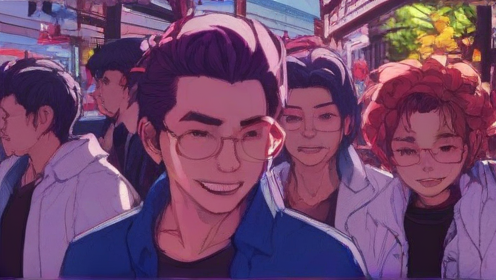

In [ ]:
output_image = results.images[0]
output_file_name = 'anime_' + image
output_image.save(output_file_name)
output_image

#### Step 6: Generate caption with Gemini

In [ ]:
API_KEY = userdata.get('gemini')
genai.configure(api_key=API_KEY)

model = genai.GenerativeModel(model_name='gemini-1.5-pro')

landmark = "Durga Puja in Kolkata" # @param {type : 'string'}
date = "13th October 2024" # @param {type : 'string'}

input_image = 'image.jpg' # @param {type : 'string'}
output_image = 'output_image.png' # @param {type : 'string'}


input_image_path = ROOT + input_image
image = Image.open(input_image_path)

output_image = ROOT + output_image
anime_image = 'anime_image.jpg' # @param {type : 'string'}

anime_image = ROOT + anime_image

prompt = "Write a short caption in maximum one line to describe a feeling suitable to the image of the landmark: " # @param {type : 'string'}
prompt = prompt + landmark

response = model.generate_content([prompt, image], stream=True)
response.resolve()

print(response.text)
caption = response.text

Soaking in the vibrant energy and joy of Durga Puja in Kolkata! 



#### Step 7: Create the photo journal

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def wrap_text(text, font, max_width):
    lines = []
    words = text.split()
    line = ''

    for word in words:
        # Check the width of the line with the new word added.
        test_line = f'{line} {word}' if line else word
        width, _ = ImageDraw.Draw(Image.new('RGB', (1, 1))).textbbox((0, 0), test_line, font=font)[2:]

        if width <= max_width:
            line = test_line
        else:
            lines.append(line)
            line = word

    if line:
        lines.append(line)

    return lines

def add_caption_to_image(original_image, animated_image, date, landmark, caption, output_path, padding=20):
    # Load images.
    original_image = Image.open(original_image)
    animated_image = Image.open(animated_image)

    # Load the custom font
    font_path = 'ComicSansMS3.ttf'
    font_size = 30
    font = ImageFont.truetype(font_path, font_size)

    draw_original_image = ImageDraw.Draw(original_image)
    text_bbox = draw_original_image.textbbox((0, 0), caption, font=font)
    text_width, text_height = text_bbox[2], text_bbox[3]

    # Calculate new dimensions
    new_original_width = original_image.width + 2 * padding
    new_original_height = original_image.height + text_height + 3 * padding

    # Create a new image with white background
    new_original_image = Image.new('RGB', (new_original_width, new_original_height), 'white')

    # Paste the original image onto the new image
    image_position = (padding, padding)
    new_original_image.paste(original_image, image_position)

    # Draw the caption
    text_position = (padding + int(original_image.width / 2.5), original_image.height + 2 * padding)
    draw_original_image = ImageDraw.Draw(new_original_image)
    draw_original_image.text(text_position, 'Original', fill='black', font=font)

    # Save the result
    new_original_image.save('original.png')

    font_size = 20
    font = ImageFont.truetype(font_path, font_size)

    # Create a drawing context for the image
    draw = ImageDraw.Draw(animated_image)

    # Prepare the text for wrapping
    date_place = f"{date}, {landmark}"
    date_place_bbox = draw.textbbox((0, 0), date_place, font=font)
    date_place_width, date_place_height = date_place_bbox[2], date_place_bbox[3]
    caption_max_width = animated_image.width - 2 * padding
    wrapped_caption_lines = wrap_text(caption, font, caption_max_width)

    # Calculate total text height
    total_text_height = date_place_height + sum(draw.textbbox((0, 0), line, font=font)[3] for line in wrapped_caption_lines) + 2 * padding

    # Calculate new dimensions
    new_animated_width = animated_image.width + 2 * padding
    new_animated_height = animated_image.height + total_text_height + padding

    # Create a new image with white background
    new_animated_image = Image.new('RGB', (new_animated_width, new_animated_height), 'white')

    # Paste the original image onto the new image
    image_position = (padding, padding)
    new_animated_image.paste(animated_image, image_position)

    # Draw the date and place
    draw = ImageDraw.Draw(new_animated_image)
    draw.text((padding + int(0.05 * original_image.width), animated_image.height + padding + 10), date_place, fill='red', font=font)

    # Draw the caption below the date and place
    y_position = animated_image.height + padding + date_place_height + padding
    for line in wrapped_caption_lines:
        text_position = (padding + int(0.05 * original_image.width), y_position)
        draw.text(text_position, line, fill=(41, 98, 255), font=font)
        y_position += draw.textbbox((0, 0), line, font=font)[3]

    # Save the animated image with caption.
    new_animated_image.save('animated_caption_image.png')

    # Merge the original and animated images side-by-side.
    width1, height1 = new_original_image.size
    width2, height2 = new_animated_image.size

    merged_width = width1 + width2
    merged_height = max(height1, height2)
    merged_image = Image.new('RGB', (merged_width, merged_height), 'white')

    # Paste the images onto the new image
    merged_image.paste(new_original_image, (0, 0))
    merged_image.paste(new_animated_image, (width1, 0))

    # Save the resulting image
    merged_image.save(output_image)

add_caption_to_image(
    resized_image_path,
    anime_image,
    date,
    landmark,
    caption,
    output_image,
)


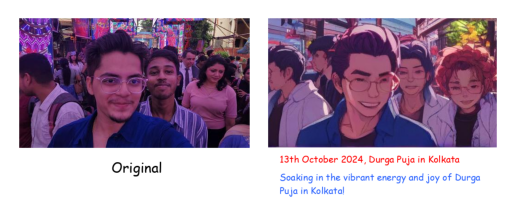

In [ ]:
merged_image = Image.open('output_image.png')

fig, ax = plt.subplots()
ax.imshow(merged_image)
ax.axis('off')
plt.show()